# Max Pool MIL

Now we're going to load and train and MIL network on MNIST (presence of 0 = positive bag).

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
import tensorflow_addons as tfa
from noisy_and import NoisyAnd
from tensorflow.keras import layers
from utils import plot_results

np.random.seed(42)
tf.random.set_seed(42)

N_CLASSES = 2
MAX_BAG = 7

print(tf.__version__)

2.4.1


In [2]:
def preprocess_mil(dataset, prefix):
  (x_train, _), (x_test, _) = dataset

  # Standardize
  x_train = x_train[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_train[..., np.newaxis]).numpy()
  x_test = x_test[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_test[..., np.newaxis]).numpy()
  
  x_train, y_train = load_mil(x_train, prefix + '_train.csv')
  x_test, y_test = load_mil(x_test, prefix + '_test.csv')

  return (x_train, y_train), (x_test, y_test)

def load_mil(x_orig, csv):
  df = pd.read_csv(csv)
  
  x = np.zeros((df.shape[0], MAX_BAG) +  x_orig[0].shape)
  for i, r in df.iterrows():
    idx = r[1:][r[1:] != -1]
    x[i, :idx.shape[0]] = x_orig[idx]
  
  y = tf.one_hot(df.y, N_CLASSES).numpy()
  
  return x, y

def load_fashion():
  return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/fashion')

def load_mnist():
  return preprocess_mil(tf.keras.datasets.mnist.load_data(), 'data/mnist')

def load_outfit():
  return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/outfit')

In [3]:
def evaluate(create_model, load_dataset, epochs=10, batch_size=64):
  (x_train, y_train), (x_test, y_test) = load_dataset()
  
  print('----- Data -----')
  print(f'Train : x={x_train.shape}, y={y_train.shape}')
  print(f'Test  : x={x_test.shape}, y={y_test.shape}')
  print(f'Splits: train={y_train.sum(axis=0).astype(int)}, test={y_test.sum(axis=0).astype(int)}')
  print('----------------') 

  model = create_model()

  return model.fit(
      x_train, y_train,
      callbacks=[ tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      ) ],
      validation_data=(x_test, y_test),
      epochs=epochs,
      batch_size=batch_size,
  )

In [4]:
def define_model():
  model = tf.keras.Sequential([
      layers.Input((MAX_BAG, 28, 28, 1)),
      layers.TimeDistributed(layers.Conv2D(64, 2, activation='relu', padding='same')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Dropout(0.3)),
      layers.TimeDistributed(layers.Flatten()),
      layers.TimeDistributed(layers.Dense(256, activation='relu')),
      layers.TimeDistributed(layers.Dropout(0.5)),
      layers.TimeDistributed(layers.Dense(N_CLASSES, activation='softmax')),
      layers.MaxPool1D(7),
      layers.Flatten(),
  ])
  
  model.compile(
      optimizer=tf.optimizers.Adam(),
      loss=tf.losses.CategoricalCrossentropy(),
      metrics=[
          tf.metrics.Precision(name='prec'),
          tf.metrics.Recall(name='rec'),
          tf.metrics.AUC(name='auc'),
          tfa.metrics.F1Score(N_CLASSES, name='f1'),
      ],
  )
  return model

print(define_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 28, 28, 64)     320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14, 14, 64)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 12, 12, 32)     18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 1152)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 256)            2

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8365 4929], test=[1402  831]
----------------
Epoch 1/10
208/208 [==============================] - 48s 222ms/step - loss: 0.4299 - prec: 0.6771 - rec: 0.9397 - auc: 0.7689 - f1: 0.5369 - val_loss: 0.2804 - val_prec: 0.7194 - val_rec: 0.9987 - val_auc: 0.8091 - val_f1: 0.5625
Epoch 2/10
208/208 [==============================] - 44s 212ms/step - loss: 0.2885 - prec: 0.7236 - rec: 0.9922 - auc: 0.8052 - f1: 0.5719 - val_loss: 0.2784 - val_prec: 0.7195 - val_rec: 0.9996 - val_auc: 0.8109 - val_f1: 0.6404
Epoch 3/10
208/208 [==============================] - 40s 191ms/step - loss: 0.2786 - prec: 0.7230 - rec: 0.9949 - auc: 0.8070 - f1: 0.5891 - val_loss: 0.2663 - val_prec: 0.7241 - val_rec: 1.0000 - val_auc: 0.8118 - val_f1: 0.6427
Epoch 4/10
208/208 [==============================] - 40s 191ms/step - loss: 0.2722 - prec: 0.7272 - rec: 0.9960 - auc: 0.8104 - f1: 0.6402

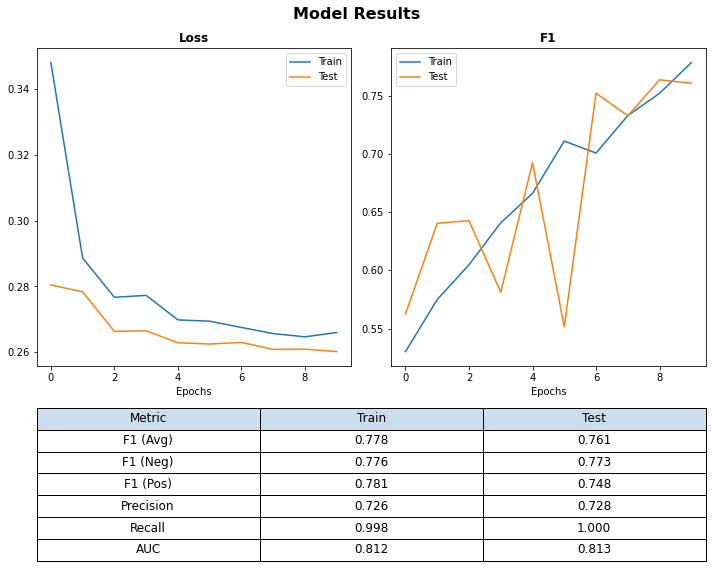

In [5]:
history = evaluate(define_model, load_mnist)
plot_results(history, filename='img/max-mnist.jpg')

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8314 4980], test=[1400  833]
----------------
Epoch 1/10
208/208 [==============================] - 42s 196ms/step - loss: 0.5255 - prec: 0.6444 - rec: 0.8577 - auc: 0.7286 - f1: 0.4896 - val_loss: 0.3118 - val_prec: 0.7153 - val_rec: 0.9910 - val_auc: 0.8007 - val_f1: 0.7208
Epoch 2/10
208/208 [==============================] - 43s 207ms/step - loss: 0.3147 - prec: 0.7157 - rec: 0.9873 - auc: 0.7939 - f1: 0.6363 - val_loss: 0.3036 - val_prec: 0.7182 - val_rec: 0.9919 - val_auc: 0.8030 - val_f1: 0.6786
Epoch 3/10
208/208 [==============================] - 43s 205ms/step - loss: 0.3035 - prec: 0.7216 - rec: 0.9907 - auc: 0.8023 - f1: 0.6879 - val_loss: 0.2995 - val_prec: 0.7175 - val_rec: 0.9928 - val_auc: 0.8055 - val_f1: 0.8201
Epoch 4/10
208/208 [==============================] - 41s 199ms/step - loss: 0.2999 - prec: 0.7203 - rec: 0.9912 - auc: 0.8029 - f1: 0.7384

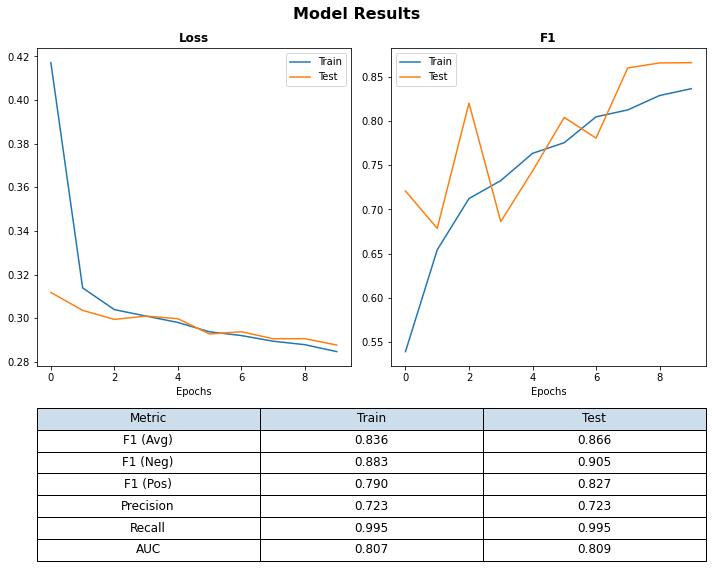

In [6]:
history = evaluate(define_model, load_fashion)
plot_results(history, filename='img/max-fashion.jpg')

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[9987 3307], test=[1683  550]
----------------
Epoch 1/10
208/208 [==============================] - 41s 190ms/step - loss: 0.5781 - prec: 0.7345 - rec: 0.7508 - auc: 0.7392 - f1: 0.4412 - val_loss: 0.5604 - val_prec: 0.7537 - val_rec: 0.7537 - val_auc: 0.7535 - val_f1: 0.4298
Epoch 2/10
208/208 [==============================] - 40s 191ms/step - loss: 0.5673 - prec: 0.7483 - rec: 0.7483 - auc: 0.7373 - f1: 0.4280 - val_loss: 0.5596 - val_prec: 0.7537 - val_rec: 0.7537 - val_auc: 0.7535 - val_f1: 0.4298
Epoch 3/10
208/208 [==============================] - 42s 202ms/step - loss: 0.5663 - prec: 0.7489 - rec: 0.7489 - auc: 0.7384 - f1: 0.4282 - val_loss: 0.5598 - val_prec: 0.7537 - val_rec: 0.7537 - val_auc: 0.7535 - val_f1: 0.4298
Epoch 4/10
208/208 [==============================] - 39s 189ms/step - loss: 0.5634 - prec: 0.7508 - rec: 0.7508 - auc: 0.7411 - f1: 0.4288

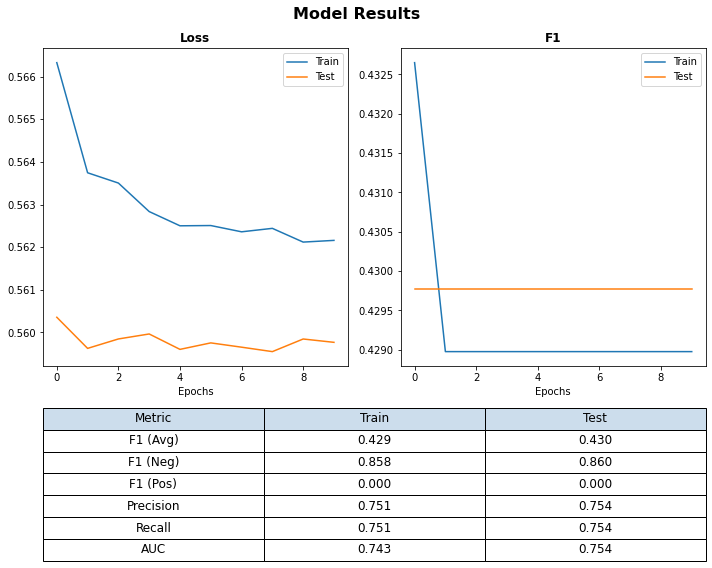

In [7]:
history = evaluate(define_model, load_outfit)
plot_results(history, filename='img/max-outfit.jpg')